# Stocks

In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import ig
import datetime as dt

In [28]:
plt.style.use('seaborn')
graph_size=(14,10)

## API Setup

In [2]:
details = ig.get_api('prod')
api = ig.APIHandler(details['url'], details['api_key'], details['user_name'], details['password'])
del details

In [5]:
api.debug_level = 0

## Price Analysis

### Historic Price Retrieval

In [4]:
# api.markets(93334)
# api.debug_level = 1
prices = api.prices('IX.D.FTSE.DAILY.IP', resolution='DAY',
                    from_date=dt.datetime(2020, 6, 1), to_date=dt.datetime.now(),
                    show_remaining_requests=True)

epic: IX.D.FTSE.DAILY.IP
from: 2020-06-01 00:00:00
to: 2020-08-19 23:52:45
https://api.ig.com/gateway/deal/prices/IX.D.FTSE.DAILY.IP/DAY/2020-06-01%2000%3A00%3A00/2020-08-19%2023%3A52%3A45
request: https://api.ig.com/gateway/deal/prices/IX.D.FTSE.DAILY.IP/DAY/2020-06-01%2000%3A00%3A00/2020-08-19%2023%3A52%3A45
page: 1
response: 200
[{'prices': [{'snapshotTime': '2020/06/01 00:00:00', 'openPrice': {'bid': 6064.1, 'ask': 6068.1, 'lastTraded': None}, 'closePrice': {'bid': 6178.0, 'ask': 6182.0, 'lastTraded': None}, 'highPrice': {'bid': 6203.0, 'ask': 6207.0, 'lastTraded': None}, 'lowPrice': {'bid': 6055.0, 'ask': 6059.0, 'lastTraded': None}, 'lastTradedVolume': 85302}, {'snapshotTime': '2020/06/02 00:00:00', 'openPrice': {'bid': 6177.5, 'ask': 6181.5, 'lastTraded': None}, 'closePrice': {'bid': 6234.2, 'ask': 6238.2, 'lastTraded': None}, 'highPrice': {'bid': 6240.6, 'ask': 6244.6, 'lastTraded': None}, 'lowPrice': {'bid': 6156.6, 'ask': 6159.7, 'lastTraded': None}, 'lastTradedVolume': 80237

### Data Manipulation

In [11]:
price_columns = [column for column in prices.columns if 'Price' in column]

for column in price_columns:
    new_columns = prices[column].apply(pd.Series)
    new_columns.columns = [column.replace('Price', '') + '_' + c for c in new_columns.columns]
    prices = prices.join(new_columns).drop(columns=column, axis=1)

,snapshotTime,lastTradedVolume,open_bid,open_ask,open_lastTraded,close_bid,close_ask,close_lastTraded,high_bid,high_ask,high_lastTraded,low_bid,low_ask,low_lastTraded
0,2020/08/13 09:00:00,5418,6213.8,6214.8,NaN,6214.0,6215.0,NaN,6217.5,6218.5,NaN,6198.3,6199.3,NaN
1,2020/08/13 10:00:00,4175,6213.8,6214.8,NaN,6219.0,6220.0,NaN,6225.8,6226.8,NaN,6212.5,6213.5,NaN
2,2020/08/13 11:00:00,4299,6218.8,6219.8,NaN,6207.3,6208.3,NaN,6227.3,6228.3,NaN,6205.3,6206.3,NaN
3,2020/08/13 12:00:00,3665,6207.5,6208.5,NaN,6214.5,6215.5,NaN,6217.0,6218.0,NaN,6206.0,6207.0,NaN
4,2020/08/13 13:00:00,4357,6214.2,6215.2,NaN,6216.5,6217.5,NaN,6219.5,6220.5,NaN,6203.5,6204.5,NaN
5,2020/08/13 14:00:00,10353,6216.0,6217.0,NaN,6197.7,6198.7,NaN,6217.7,6218.7,NaN,6188.5,6189.5,NaN
6,2020/08/13 15:00:00,8984,6197.5,6198.5,NaN,6191.6,6192.6,NaN,6200.8,6201.8,NaN,6187.6,6188.6,NaN
7,2020/08/13 16:00:00,14237,6191.8,6192.8,NaN,6185.3,6187.3,NaN,6198.3,6199.6,NaN,6180.6,6182.6,NaN
8,2020/08/13 17:00:00,1751,6185.6,6187.6,NaN,6191.1,6193.1,NaN,6193.3,6195.3,NaN,6185.1,6187.1,NaN
9,2020/08/13 18:00:00,1138,6191.3,6193.3,NaN,6186.6,6188.6,NaN,6193.3,6195.3,NaN,6177.8,6179.8,NaN


In [12]:
prices = (prices.rename(columns={'snapshotTime': 'time', 'lastTradedVolume': 'volume'})
          .dropna(axis=1)
         )
prices.time = pd.to_datetime(prices.time)
prices

,time,volume,open_bid,open_ask,close_bid,close_ask,high_bid,high_ask,low_bid,low_ask
0,2020-08-13 09:00:00,5418,6213.8,6214.8,6214.0,6215.0,6217.5,6218.5,6198.3,6199.3
1,2020-08-13 10:00:00,4175,6213.8,6214.8,6219.0,6220.0,6225.8,6226.8,6212.5,6213.5
2,2020-08-13 11:00:00,4299,6218.8,6219.8,6207.3,6208.3,6227.3,6228.3,6205.3,6206.3
3,2020-08-13 12:00:00,3665,6207.5,6208.5,6214.5,6215.5,6217.0,6218.0,6206.0,6207.0
4,2020-08-13 13:00:00,4357,6214.2,6215.2,6216.5,6217.5,6219.5,6220.5,6203.5,6204.5
5,2020-08-13 14:00:00,10353,6216.0,6217.0,6197.7,6198.7,6217.7,6218.7,6188.5,6189.5
6,2020-08-13 15:00:00,8984,6197.5,6198.5,6191.6,6192.6,6200.8,6201.8,6187.6,6188.6
7,2020-08-13 16:00:00,14237,6191.8,6192.8,6185.3,6187.3,6198.3,6199.6,6180.6,6182.6
8,2020-08-13 17:00:00,1751,6185.6,6187.6,6191.1,6193.1,6193.3,6195.3,6185.1,6187.1
9,2020-08-13 18:00:00,1138,6191.3,6193.3,6186.6,6188.6,6193.3,6195.3,6177.8,6179.8


### Analysis

In [16]:
prices.to_pickle('prices.pkl')

In [21]:
prices['buy_profit'] = prices.close_bid - prices.open_ask
prices['buy_stop'] = prices.low_bid - prices.open_ask
prices['buy_limit'] = prices.high_bid - prices.open_ask
prices['sell_profit'] = -(prices.close_ask - prices.open_bid)
prices['sell_stop'] = prices.high_ask - prices.open_bid
prices['sell_limit'] = prices.low_ask - prices.open_bid
prices

,time,volume,open_bid,open_ask,close_bid,close_ask,high_bid,high_ask,low_bid,low_ask,buy_profit,buy_stop,buy_limit,sell_profit,sell_stop,sell_limit
0,2020-06-01,85302,6064.1,6068.1,6178.0,6182.0,6203.0,6207.0,6055.0,6059.0,109.9,-13.1,134.9,-117.9,142.9,-5.1
1,2020-06-02,80237,6177.5,6181.5,6234.2,6238.2,6240.6,6244.6,6156.6,6159.7,52.7,-24.9,59.1,-60.7,67.1,-17.8
2,2020-06-03,95950,6233.7,6237.7,6375.5,6379.5,6406.9,6408.9,6233.7,6237.7,137.8,-4.0,169.2,-145.8,175.2,4.0
3,2020-06-04,93140,6375.2,6379.2,6342.8,6346.8,6412.2,6416.2,6311.6,6312.6,-36.4,-67.6,33.0,28.4,41.0,-62.6
4,2020-06-05,96876,6343.1,6347.1,6454.0,6458.0,6500.0,6502.0,6328.8,6331.8,106.9,-18.3,152.9,-114.9,158.9,-11.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
64,2020-08-14,91047,6188.8,6192.8,6076.5,6080.5,6201.8,6203.8,6033.2,6034.2,-116.3,-159.6,9.0,108.3,15.0,-154.6
65,2020-08-16,0,6083.0,6087.0,6085.3,6089.3,6086.7,6090.7,6080.4,6084.4,-1.7,-6.6,-0.3,-6.3,7.7,1.4
66,2020-08-17,62223,6085.5,6089.5,6121.6,6125.6,6140.4,6141.4,6057.4,6058.4,32.1,-32.1,50.9,-40.1,55.9,-27.1
67,2020-08-18,73283,6120.9,6124.9,6078.7,6082.7,6163.9,6164.9,6057.6,6058.6,-46.2,-67.3,39.0,38.2,44.0,-62.3


In [22]:
mondays = prices[(prices.time.dt.weekday == 0)]
fridays = prices[(prices.time.dt.weekday == 4)]

#### Maximum Profit

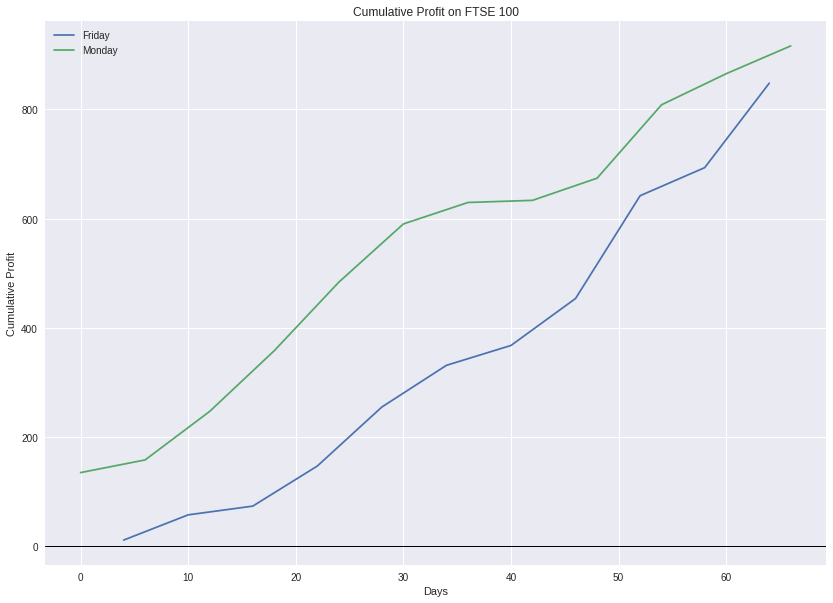

In [36]:
ax = (-fridays.sell_limit).cumsum().plot(figsize=graph_size, legend=True, title='Cumulative Profit on FTSE 100')
ax = mondays.buy_limit.cumsum().plot(figsize=graph_size, legend=True)
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Profit')
ax.axhline(y=0, color='k', linewidth=1)
ax.legend(['Friday', 'Monday'])

#### Full-day Profit

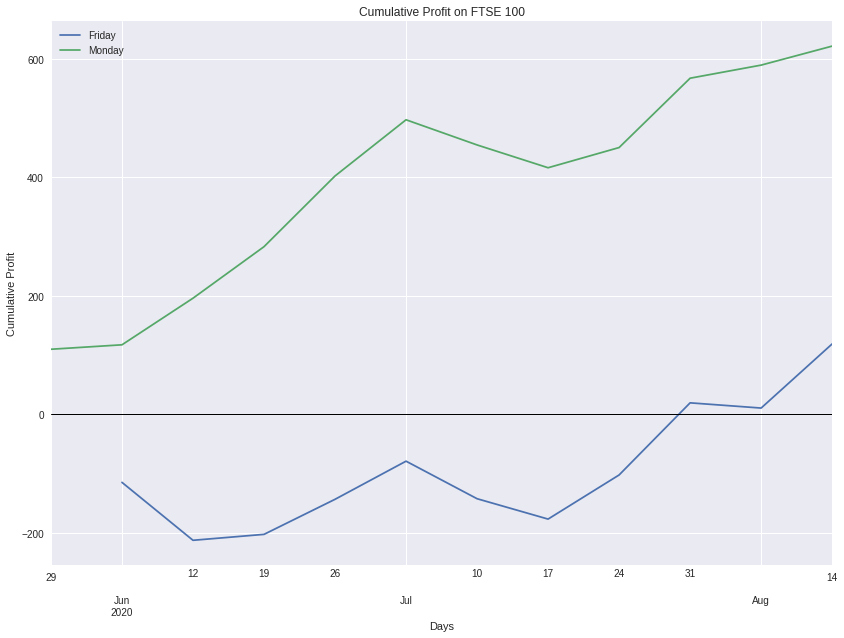

In [43]:
ax = fridays.set_index('time').sell_profit.cumsum().plot(figsize=graph_size, legend=True, title='Cumulative Profit on FTSE 100')
ax = mondays.set_index('time').buy_profit.cumsum().plot(figsize=graph_size, legend=True)
ax.set_xlabel('Days')
ax.set_ylabel('Cumulative Profit')
ax.axhline(y=0, color='k', linewidth=1)
ax.legend(['Friday', 'Monday'])

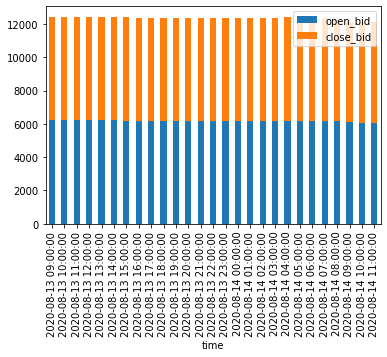

In [6]:
df.set_index('time')[['open_bid', 'close_bid']].plot.bar(stacked=True)